## Chapter 4: Second order methods

# 4.7  Quasi-Newton methods

While Newton's method is a powerful technique that exhibits rapid convergence for a (especially) convex function $g\left(\mathbf{w}\right)$, it is naturally constrained by $N$ the dimension of the input $\mathbf{w}$.  In particular it is the quadratic generating Hessian $\nabla^2g\left(\mathbf{w}\right)$, an $N\times N$ matrix that limits Newton's method's use to cases where $N$ is (roughly speaking) in the thousands, since it is difficult to even store such a matrix when $N$ is larger (let alone compute with it).  In this Section we give discuss a set of variations on Newton's method that are designed to ameliorate this issue, collectively referred to as *quasi-Newton's methods*.  The main thrust of any such method is - in the Newton-like step - to replace the Hessian with a close approximation that does not suffer from this scaling problem.  

In [1]:
#  This code cell will not be shown in the HTML version of this notebook
# imports from custom libraries

import sys
sys.path.append('../../')

from mlrefined_libraries import math_optimization_library as optilearn
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad as compute_grad   # The only autograd function you may ever need

import math
import pandas as pd
import copy

%matplotlib notebook
%load_ext autoreload
%autoreload 2

## 4.7.1  Newton's method from the perspective of the gradient function

We have just seen how Newton's method works to find stationary points of a cost function, points where the gradient of the cost function is zero, effectively minimizing the function.  However the classic application of Newton's method is actually towards finding the *zeros* of (polynomial) functions - that is where a function crosses the input plane.  At first glance it may not seem like the Newton's method - at least the way we have viewed it thus far - is applicable to such problems.  That is until we think about what Newton's method is doing in the space where the *gradient of our cost function* lives.  If Newton's method does indeed take steps towards finding the stationary point of a cost function then then we can we can indeed view these steps evaluated not on the cost function, but on the derivative (or gradient more generally) itself.  Any sequence of steps moving towards a stationary point of the cost function itself is naturally - when evaluated by the gradient - a sequence of steps moving towards a zero of the gradient function.

Because we will be frequently be manipulating first and second derivatives here, in this Section we will make use of the common (more compact) 'prime' notation to denote the first and second derivative of a single input function $g(w)$

\begin{equation}
g^{\prime}(w) = \frac{\mathrm{d}}{\mathrm{d}w}g\left(w\right) \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,g^{\prime\prime}(w) = \frac{\mathrm{d}^2}{\mathrm{d}w^2}g\left(w\right).
\end{equation}

Now, remember when $N = 1$ the $k^{th}$ that the Newton's step follows directly from the second order Taylor series approximation centered at a point ${w}^{k-1}$ which (in our 'prime' derivative notation) is

\begin{equation}
h\left(w\right)=g\left(w^{k-1}\right)+g^{\prime}\left(w^{k-1}\right)\left(w-w^{k-1}\right)+ g^{\prime\prime}\left(w^{k-1}\right)\left(w-w^{k-1}\right)^{2} 
\end{equation}

We want to determine a stationary point of this quadratic (a global minimum of the quadratic if it is convex) by setting the derivative of this quadratic approximation to zero and solving.  This gives our Newton step 

\begin{equation}
w^k = w^{k-1} - \frac{g^{\prime}(w^{k-1})}{g^{\prime\prime}(w^{k-1})}
\end{equation}

By following this sequence of steps we are - when beginning in a convex region of a function -  led to a stationary point which is also a local minimum of $g$.  Now, since any stationary point of $g$ is satisfies $g^{\prime}(w) = 0$, we can think of this simultaneously as a procedure for finding a *zero of our derivative function*.  Indeed we can easily derive this same Newton's method update equation *beginning* with the derivative, and with the desire to find a zero point of it.  Let us go about doing this.

So, suppose start from scratch and we do not know about Newton's method, we are simply looking for an iterative way to find a zero of our cost function derivative $g^{\prime}(w) = 0$  - What could we do?  Finding zeros of an arbitrary function is not a trivial affair. As with our discussion of the first order condition - where we discussed just this issue - we would in general look to develop an iterative scheme for *approximating* zero points of an arbitrary function $g^{\prime}$.  If we followed precisely the intuition that led us to gradient descent we would likewise conclude that while it is difficult to compute the zero of arbitrary function, it is trivial to compute where a line or hyperplane.  So why not repeatedly seek out the zero point(s) of the first order Taylor series approximation (a tangent line or hyperplane) to the function $g^{\prime}$?

#### <span style="color:#a50e3e;">Example 1. </span>  Illustrating the zero-finding algorithm concept

Below we animate the iterative scheme for finding a zero of an arbitrary function $g^{\prime}$ - here a sinusoid - based on repeatedly using the tangent line (our first order approximation) to a function and finding its zero.  As yo move the slider from left to right the scheme progresses with the point of tangency shown as a colored circle, with its corresponding input shown as an 'x' symbol.  The tangent point / input point along with the tangent line are all colored green - when the method begins - and transition to red as the method halts.  The input where the tangent line crosses the input axis is marked with a white 'x' symbol at each step, and the corresponding function evaluation (the point at which the next tangent line will be drawn) is shown as a white circle.  Moving the slider from left to right progresses the algorithm.


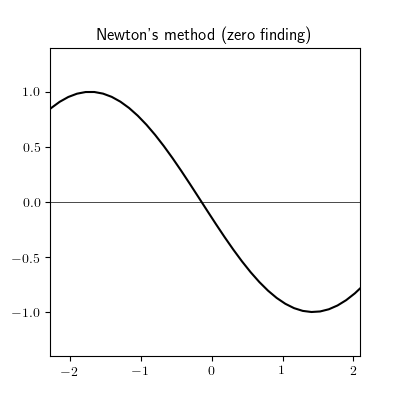
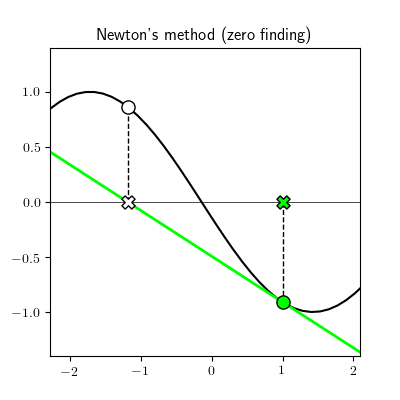
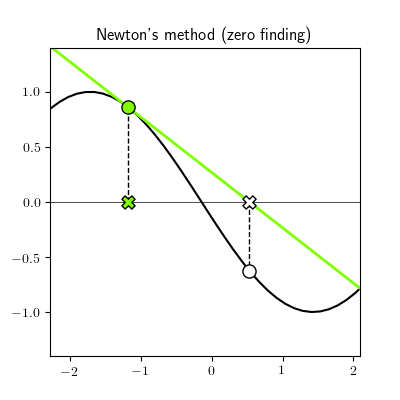
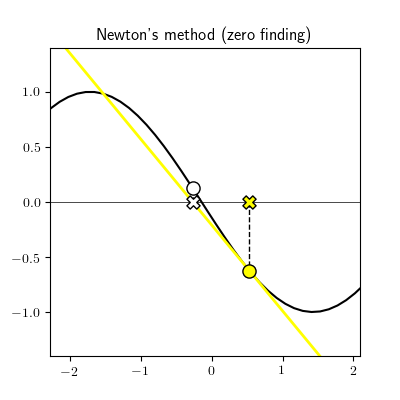
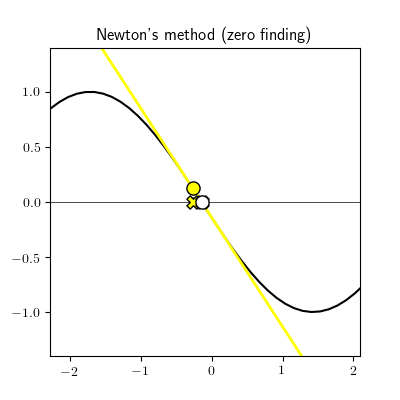
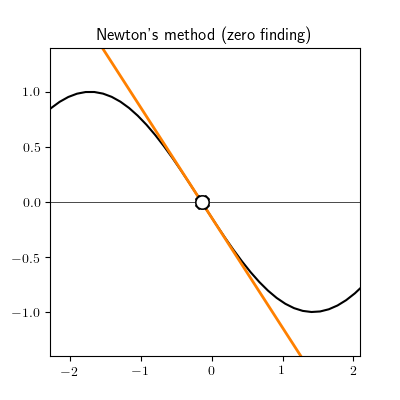
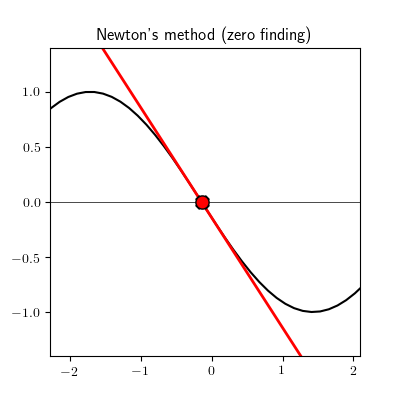

In [2]:
# This code cell will not be shown in the HTML version of this notebook
# what function should we play with?  Defined in the next line, along with our fixed point where we show tangency.
g = lambda w: np.sin((w - 3))

# create an instance of the visualizer with this function
st = optilearn.newton_secant_zero_finder.visualizer(g = g)

# run the visualizer for our chosen input function and initial point
st.draw_it_newton(w_init = 1)

---

To write out the first step of this scheme, remember first and foremost that we are thinking of this as an iterative method applied to the derivative function $g^{\prime}(w)$ - this is the function we want to find zero points of i.e., inputs where $g^{\prime}(w) = 0$.  This means - beginning at a point $w^0$ - that our linear approximation to the derivative function naturally involves the *second derivative* of the function $g$.  We can write the first order Taylor series linear approximation to the derivative function at $w^0$ as

\begin{equation}
h\left(w^0\right) = g^{\prime}\left(w^0\right) + g^{\prime \prime}\left(w^0\right)\left(w - w^0\right).
\end{equation}

Here the second derivative $g^{\prime \prime}\left(w^0 \right)$ is the slope of the tangent line to $g^{\prime}$ at the point $w^0$.  We can easily compute where this line crosses the input axis by setting the equation above to zero

\begin{equation}
g^{\prime}\left(w^0\right) + g^{\prime \prime}\left(w^0\right)\left(w - w^0\right) = 0
\end{equation}

and solving for $w$.  Doing this, and calling the solution $w^1$, we have 

\begin{equation}
w^1 = w^0 - \frac{g^{\prime}\left(w^0\right)}{g^{\prime \prime}\left(w^0\right) }.
\end{equation}

If we then repeat this procedure - finding where the tangent line at $w^1$ crosses the input axis and solving for the next update etc., - then the $k^{th}$ update step then look like

\begin{equation}
w^k = w^{k-1} - \frac{g^{\prime}\left(w^{k-1}\right)}{g^{\prime \prime}\left(w^{k-1}\right) }.
\end{equation}

Notice - these are Newton steps!  So - in other words - we have re-derived Newton's method as a zero-finding algorithm for directly solving the first order optimality condition for single input functions.

Precisely the same reasoning as we followed above for multi-input functions leads to the multi-input Newton's step as well.  So - indeed - we can view Newton's method simultaneously as

- a method for determining a stationary point (preferably a minimum) of a cost function $g(\mathbf{w})$


- a method for finding a zero of the derivative function, i.e., where  $\nabla g(\mathbf{w}) = \mathbf{0}_{N\times 1}$.

#### <span style="color:#a50e3e;">Example 2. </span>  Thinking of Newton's method in two ways simultaneously

Below we show an animation that simultaneously draws Newton's method from a) the perspective of minimizing a function (left panel) and b) finding the zero of its derivative(s) (right panel).  In particular we use the following function

\begin{equation}
g(w) = \frac{1}{50}\left(w^4 + w^2 + 10w\right).
\end{equation}

As you move the slider from left to right Newton's method proceeds in both panels, with the final step shown when the slider is moved all the way to the right.  At each step in the algorithm the input and point of tangency are drawn as a white circle and 'x' symbol respectively, while the next step input / tangency are colored from green to red as the method proceeds.  The tangent quadratic / line is also drawn in each panel, and are colored from green to red as the method proceeds as well.


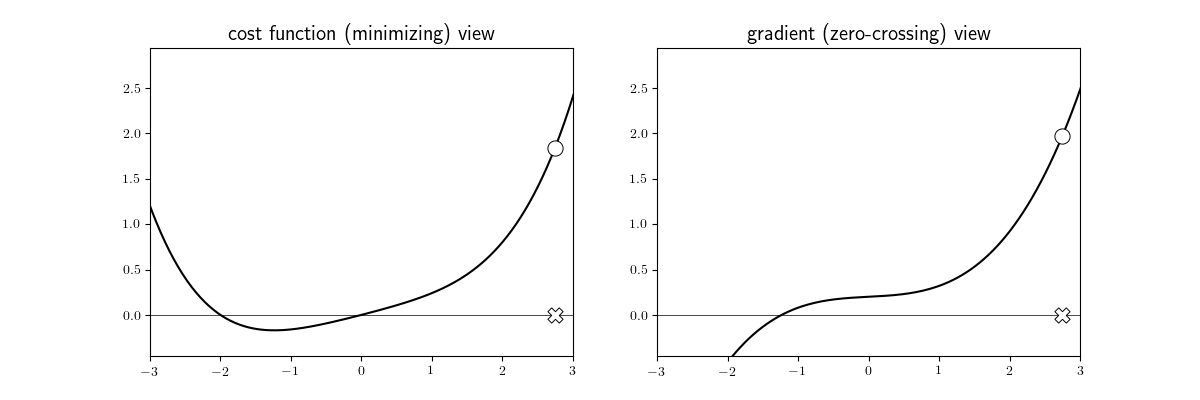
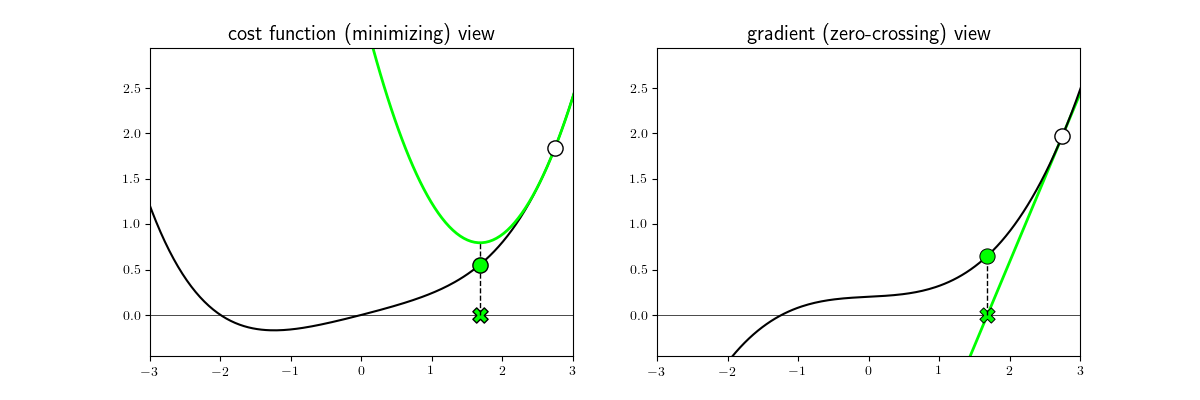
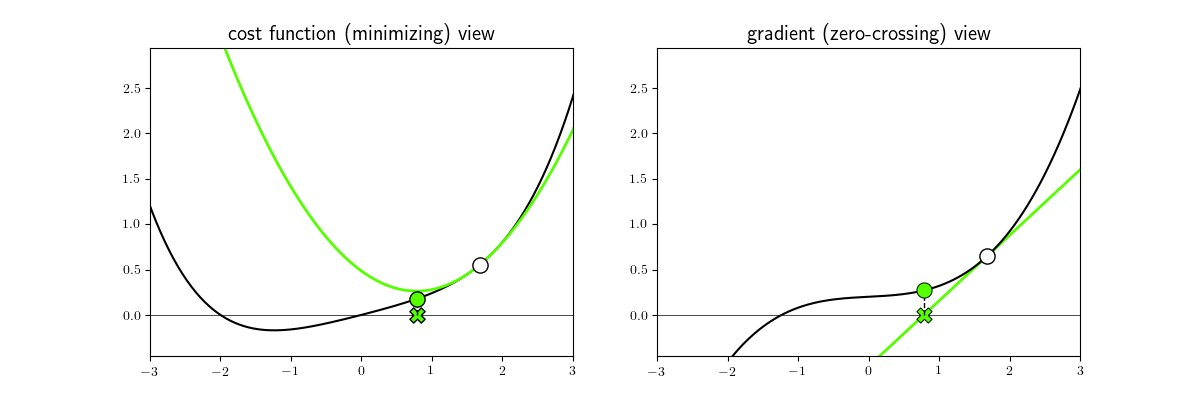
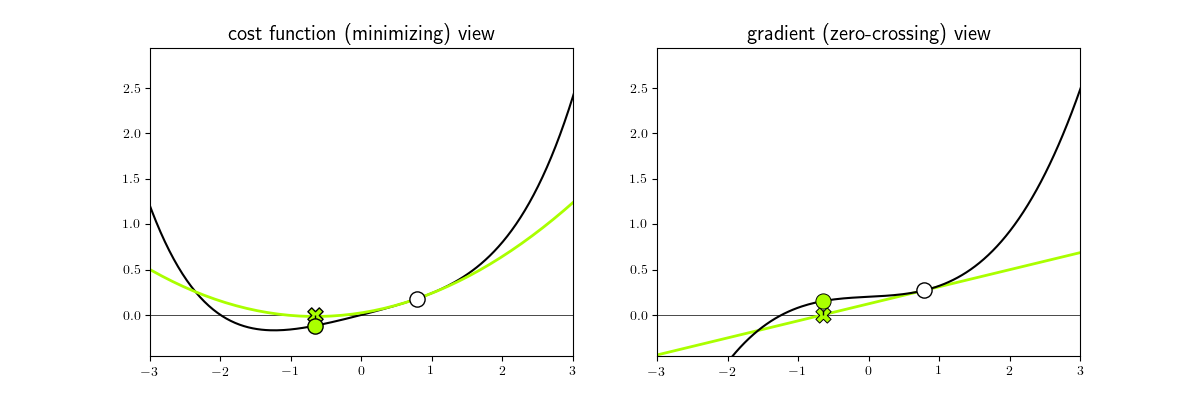
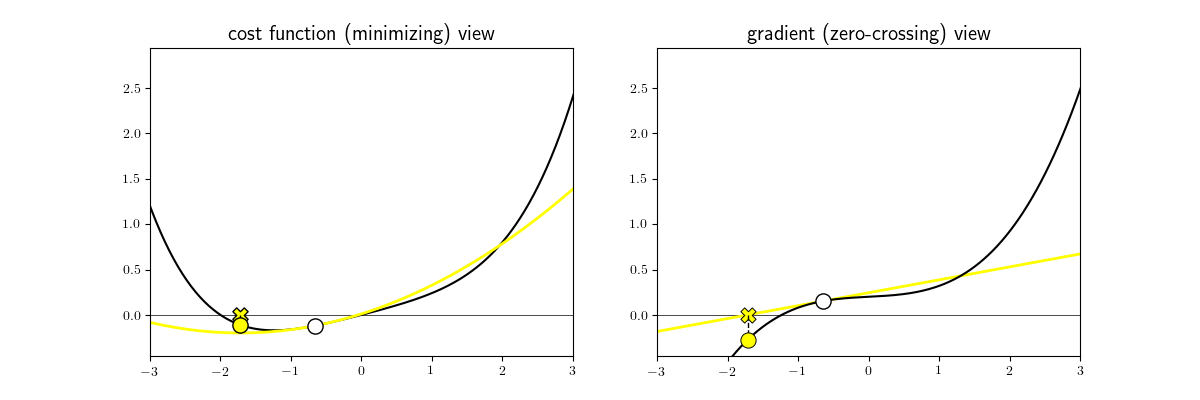
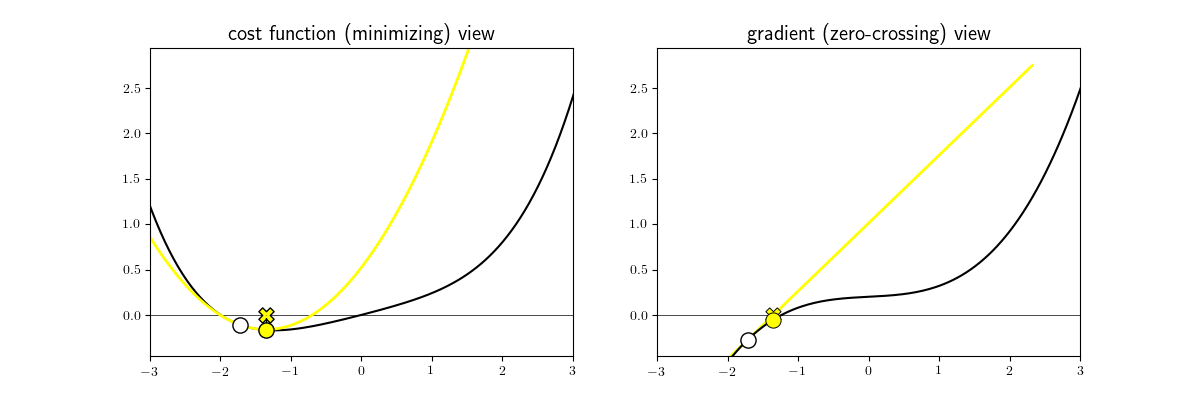
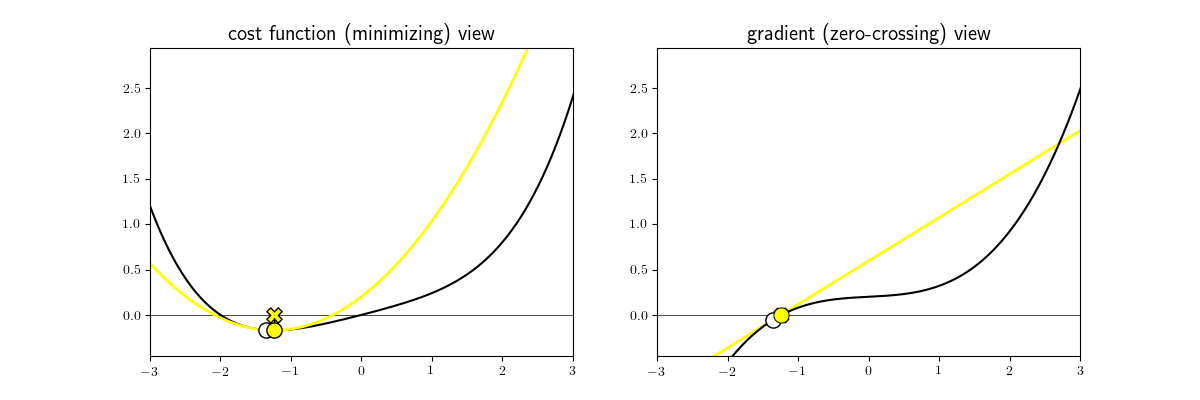
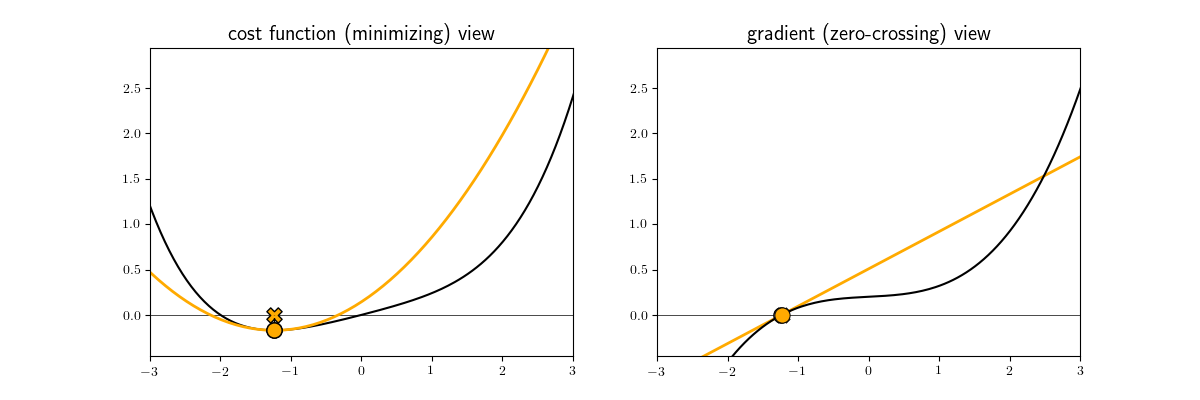
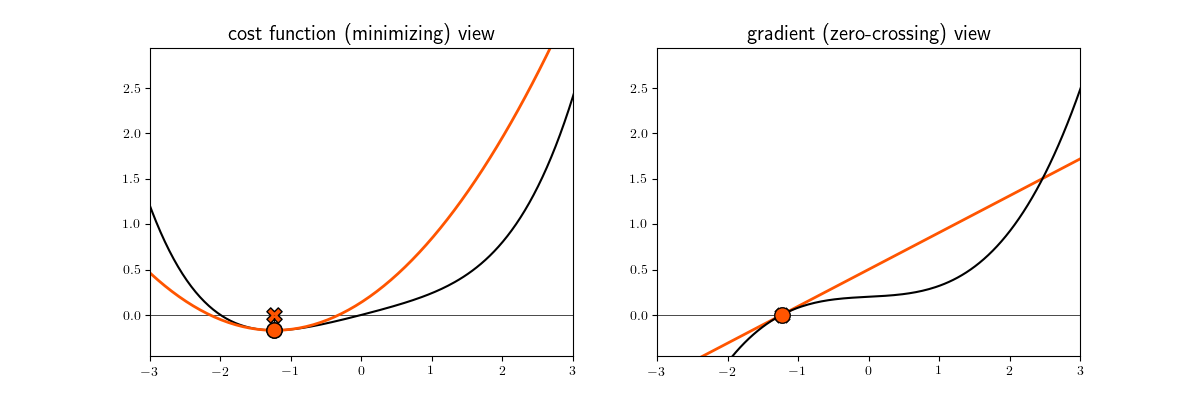
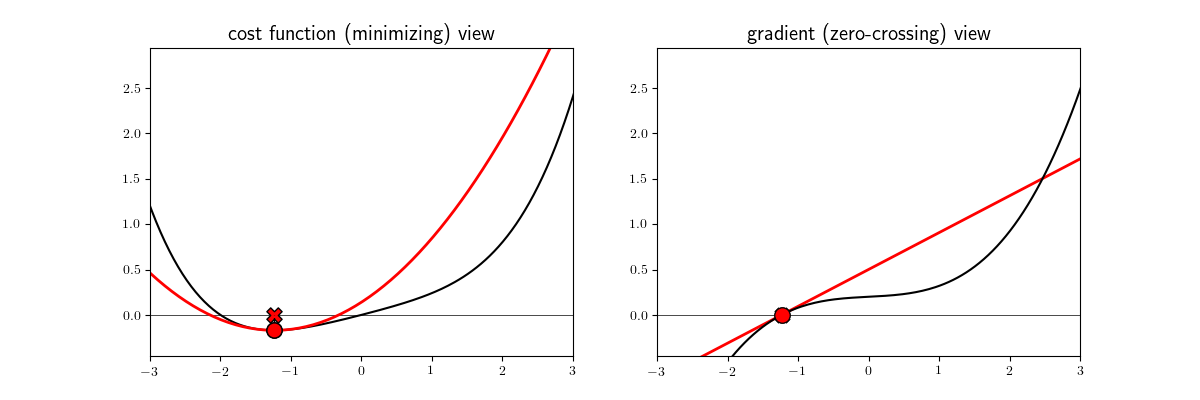

In [3]:
# This code cell will not be shown in the HTML version of this notebook
# what function should we play with?  Defined in the next line.
g = lambda w: 1/float(50)*(w**4 + w**2 + 10*w)   # try other functions too!  Like g = lambda w: np.cos(2*w) , g = lambda w: np.sin(5*w) + 0.1*w**2, g = lambda w: np.cos(5*w)*np.sin(w)

# create an instance of the visualizer with this function
minimize_zerofind = optilearn.minimize_zero_find_simultaneous.visualizer(g = g)

# run the visualizer for our chosen input function, initial point, and step length alpha
minimize_zerofind.draw_it_newtons(w_init = 2.75,max_its = 20)

## 4.7.2  Approximating the second derivative and the secant method

Remember (as discussed in Chapter 3) that the derivative of a single input function defines the slope of the tangent line to a function at a point.  Moreover the derivative/slope of a tangent line can be roughly approximated as the slope of a nearby *secant line*, that is a line that passes through the same point as well as another point nearby on the function (see Section 3.2).

Using this fact in our current scenario of Newton's method as a zero-finding algorithm, we can then say that the slope of the tangent line to our derivative function $g^{\prime}(w)$ - this slope being the second derivative itself $g^{\prime \prime}(w)$ - can itself be approximated by the slope of a nearby secant line as

\begin{equation}
g^{\prime\prime}(w) \approx \frac{g^{\prime}(w^{\,}) - g^{\prime}(v^{\,})}{w^{\,} - v^{\,}}
\end{equation}

if $v$ is taken close enough to the evaluation point $w$.  Using this rule somewhat loosely if we then go back to our Newton step and swap out the second derivative evaluation with this secant approximation we have a generic step that looks like

\begin{equation}
w^k = w^{k-1} - \frac{g^{\prime}\left(w^{k-1}\right)}{ \frac{g^{\prime}(w^{k-1}) - g^{\prime}(w^{k-2})}{w^{k-1} - w^{k-2}} }.
\end{equation}

We can write this less cumbersomely as

\begin{equation}
w^k = w^{k-1} - \frac{g^{\prime}\left(w^{k-1}\right)}{s^{k-1}}
\end{equation}

where $s^{k-1}$ has been used to replace the second derivative, and is defined as

\begin{equation}
s^{k-1} = \frac{g^{\prime}(w^{k-1}) - g^{\prime}(w^{k-2})}{w^{k-1} - w^{k-2}}.
\end{equation}

 This approach - called the *Secant method* since it employs a secant instead of a tangent line - can still determine zeros of a derivative function $g^{\prime}(w)$ / stationary points of the cost $g(w)$, but without the explicit need for the second derivative.  This fact - while fairly inconsequential for a $N = 1$ dimensional input function - gains significantly more value when the *Secant method* idea is generalized to multi-input functions (since it is the very size of the Hessian that prohibits Newton's method's use for function's with larger values of $N$).

#### <span style="color:#a50e3e;">Example 3. </span>  The Secant method from two perspectives

Below we show an animation that simultaneously draws the Secant method from a) the perspective of minimizing a function (left panel) and b) finding the zero of its derivative(s) (right panel).  In particular we use the following function

\begin{equation}
g(w) = \frac{1}{50}\left(w^4 + w^2 + 10w\right).
\end{equation}

As you move the slider from left to right Newton's method proceeds in both panels, with the final step shown when the slider is moved all the way to the right.  At each step in the algorithm the input and point of tangency are drawn as a white circle and 'x' symbol respectively, while the next step input / tangency are colored from green to red as the method proceeds.  The tangent quadratic / line is also drawn in each panel, and are colored from green to red as the method proceeds as well.


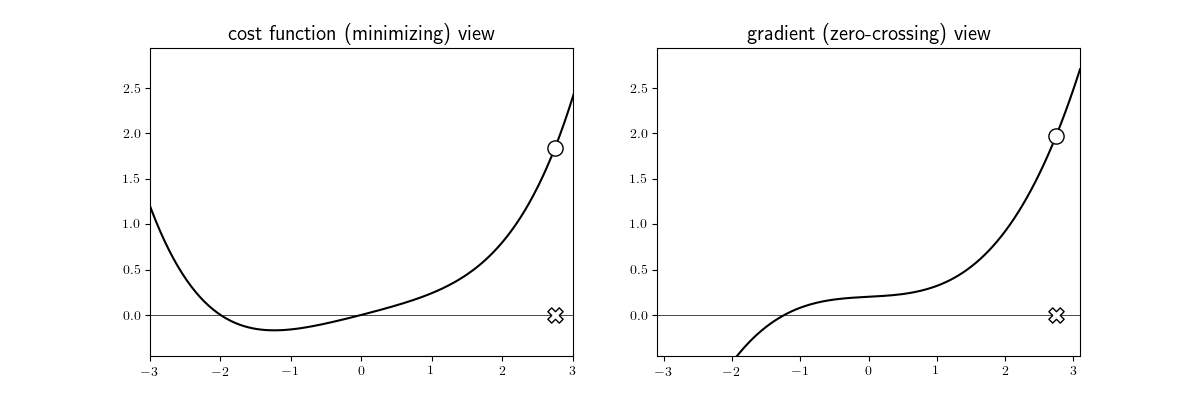
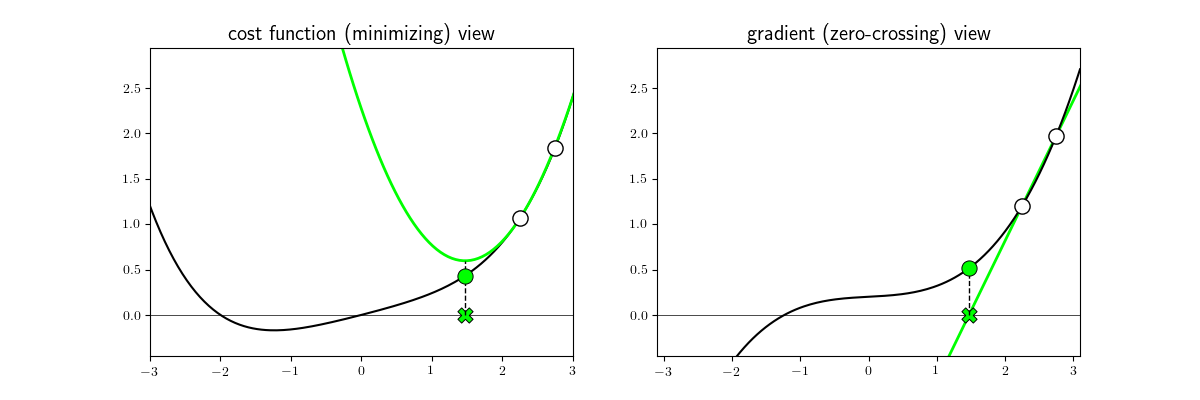
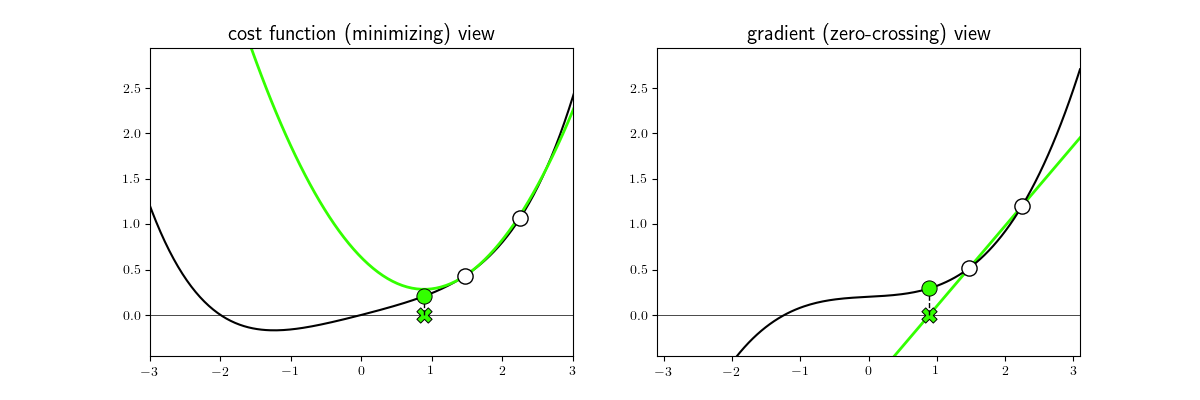
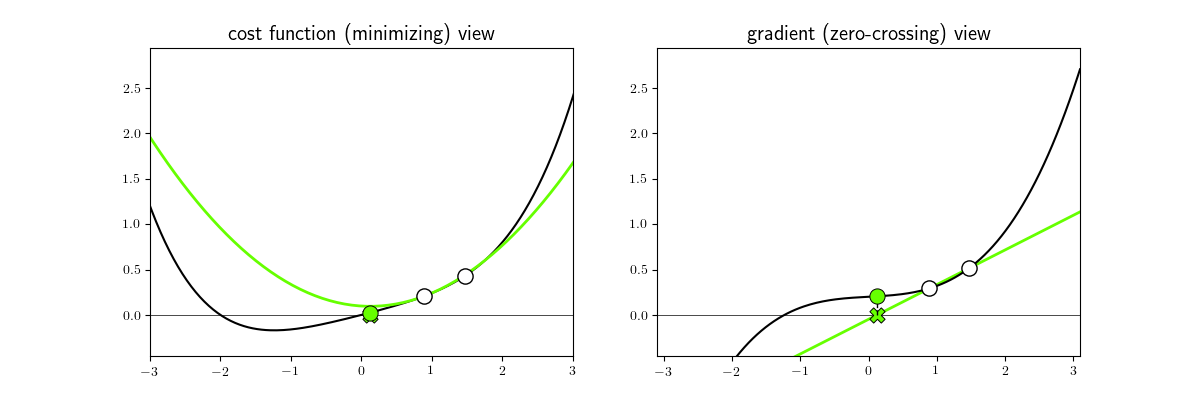
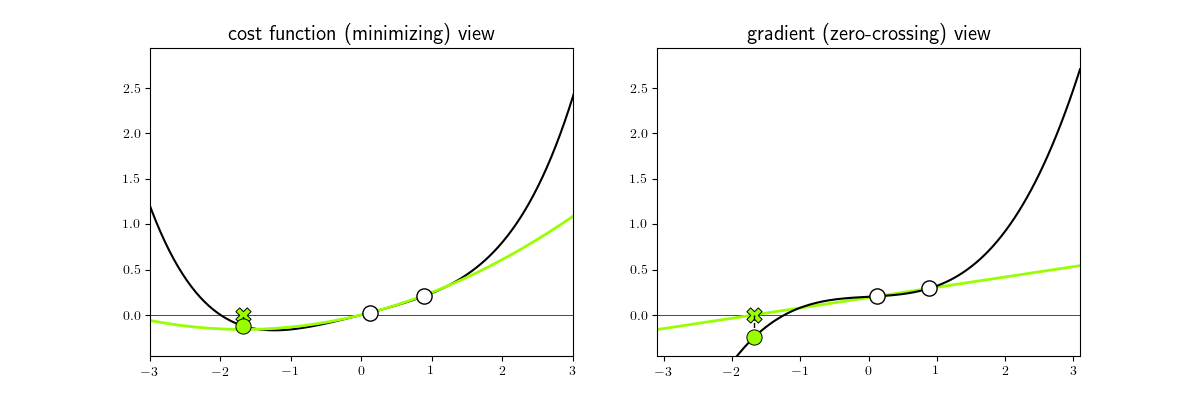
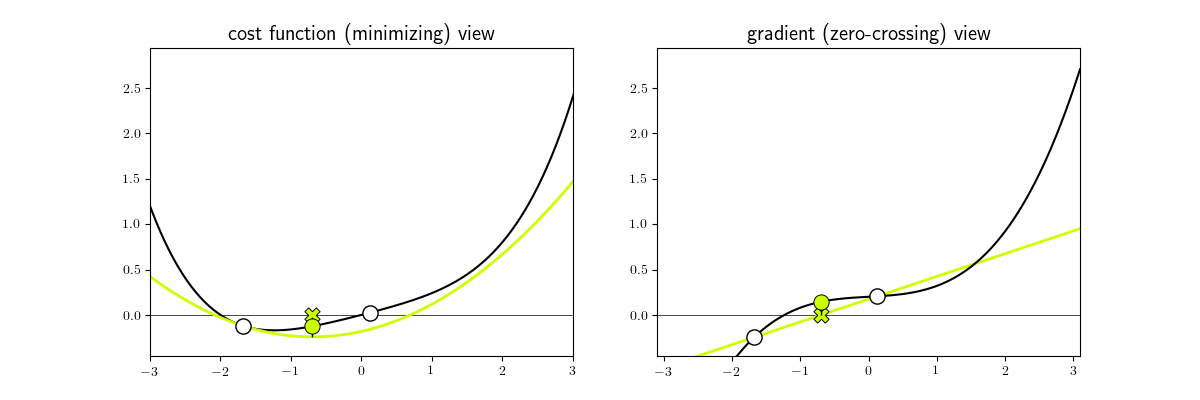
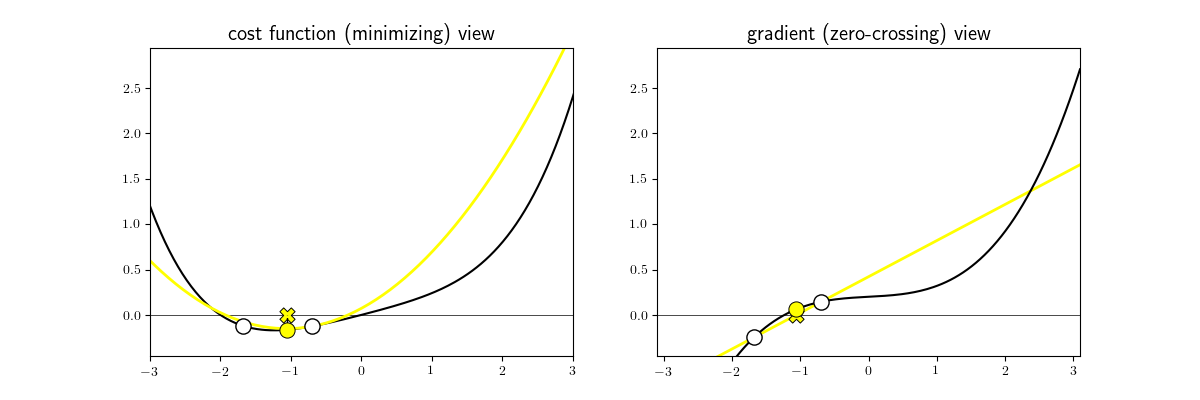
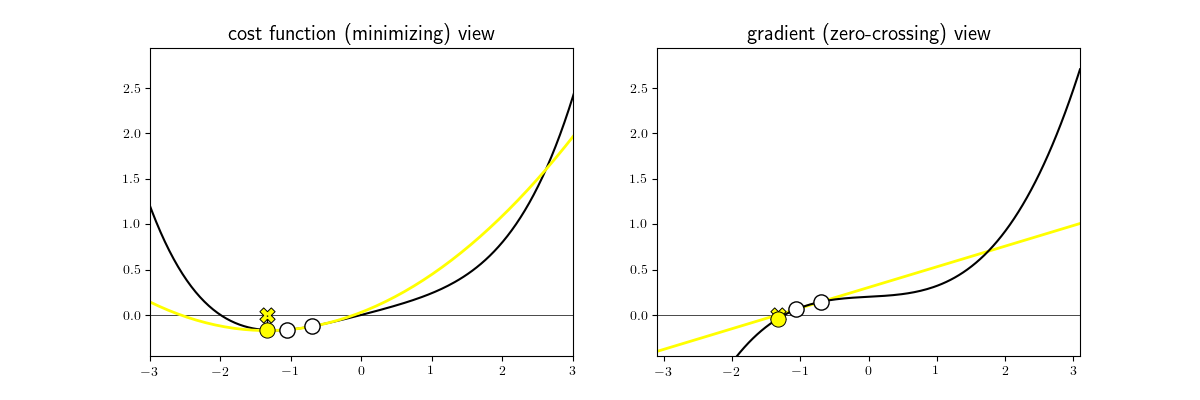
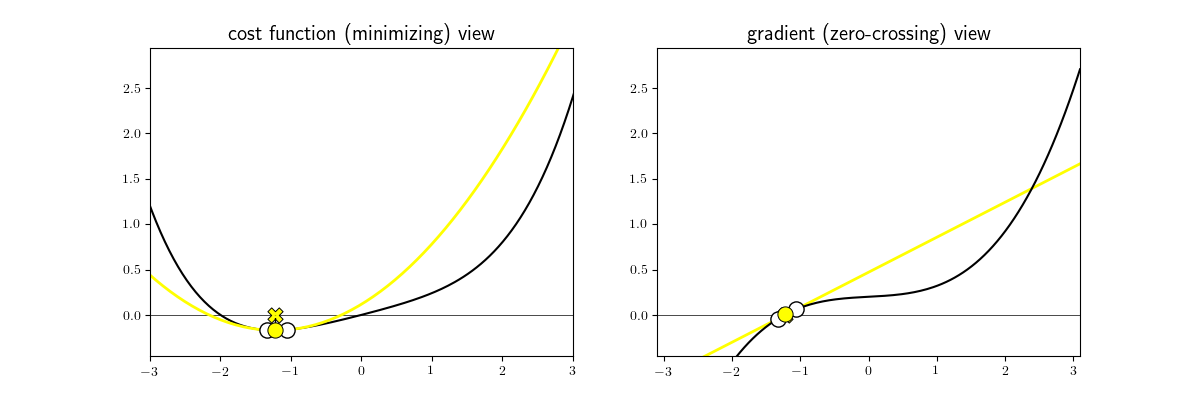
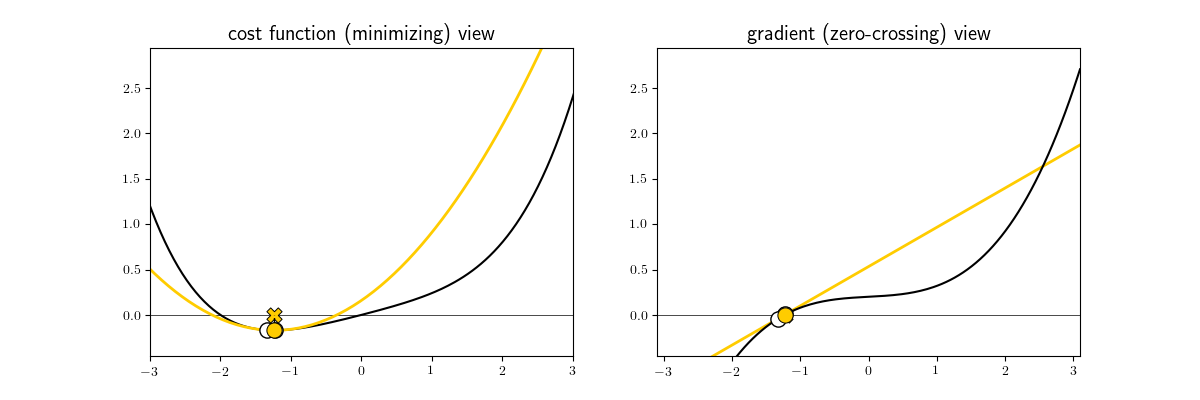
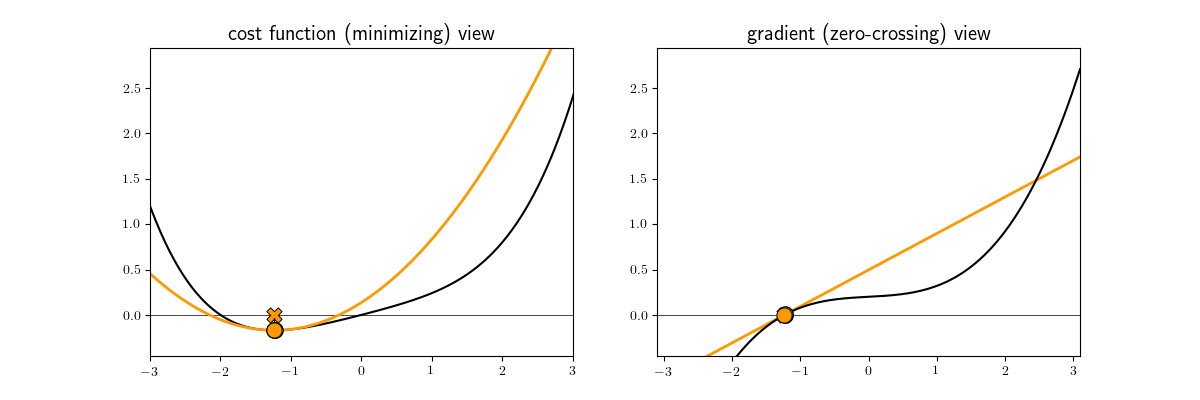
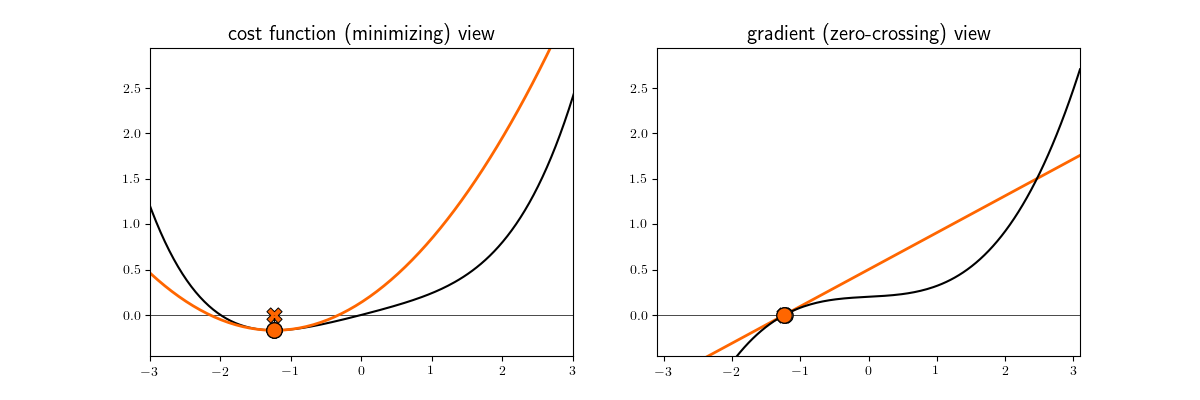
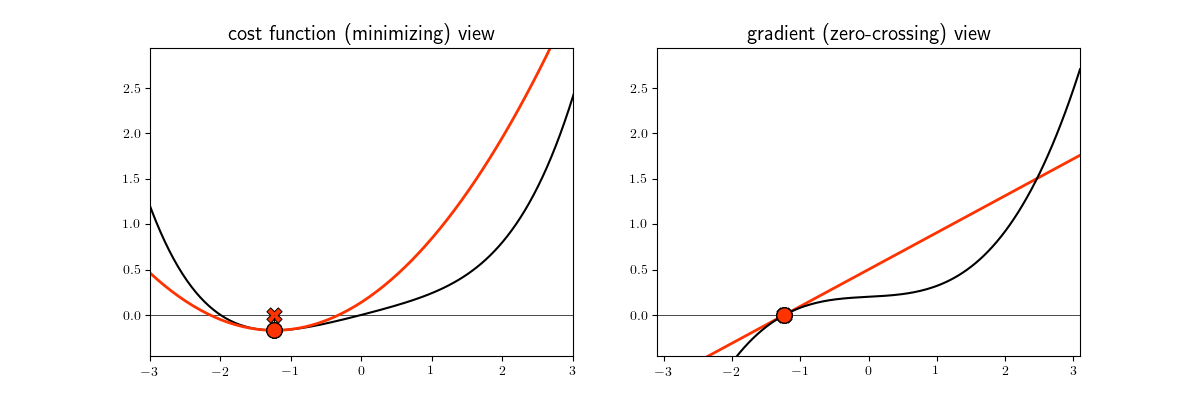

In [4]:
# This code cell will not be shown in the HTML version of this notebook
# what function should we play with?  Defined in the next line.
g = lambda w: 1/float(50)*(w**4 + w**2 + 10*w)   # try other functions too!  Like g = lambda w: np.cos(2*w) , g = lambda w: np.sin(5*w) + 0.1*w**2, g = lambda w: np.cos(5*w)*np.sin(w)

# create an instance of the visualizer with this function
minimize_zerofind = optilearn.minimize_zero_find_simultaneous.visualizer(g = g)

# run the visualizer for our chosen input function, initial point, and step length alpha
minimize_zerofind.draw_it_secant(w_init = 2.75,max_its = 20)

## 4.7.3  The general $N$ dimensional input Secant method 

Everything we have discussed for the generic single input $N= 1$ dimensional case tracks to the higher dimensional instance as well, with one important difference.  Looking back at the Subsection above we replaced the second derivative with the slope of the corresponding secant line $s^{k-1} = \frac{g^{\prime}(w^{k-1}) - g^{\prime}(w^{k-2})}{w^{k-1} - w^{k-2}}$ as

\begin{equation}
g^{\prime \prime}(w^{k-1}) \longleftarrow s^{k-1}
\end{equation}

What is this analogous replacement when $N > 1$?   Abusing notation for a moment, we could express it as (this is incorrect mathematically speaking, but the algebra mirrors the one dimensional case) by literally just upgrading each piece of notation on the right hand side of the equality above to its vector analog giving 

\begin{equation}
\mathbf{S}^{k-1} = \frac{\nabla g\left(\mathbf{w}^{k-1}\right) - \nabla g\left(\mathbf{w}^{k-2}\right)}{\mathbf{w}^{k-1} - \mathbf{w}^{k-2}}.
\end{equation}

In this case, since we are replacing the Hessian the variable $\mathbf{S}^{k-1}$ must also be an $N\times N$ matrix.  However we cannot - strictly speaking - express the right hand side of the equality above, since this would mean we are (algebraically) dividing $N$ an length vector (the numerator) by an $N$ length vector (the denominator).   The proper $N$ dimensional analog of the $N=1$ dimensional replacement is in fact a solution to the system

\begin{equation}
 \mathbf{S}^{k-1}\left(\mathbf{w}^{k-1} - \mathbf{w}^{k-2}\right)  =   \nabla g\left(\mathbf{w}^{k-1}\right) - \nabla g\left(\mathbf{w}^{k-2}\right).
\end{equation}

Likewise - inverting $\mathbf{S}^{k-1}$ - we could express this statement as

\begin{equation}
\mathbf{w}^{k-1} - \mathbf{w}^{k-2} =   \left(\mathbf{S}^{k-1}\right)^{-1}\left(\nabla g\left(\mathbf{w}^{k-1}\right) - \nabla g\left(\mathbf{w}^{k-2}\right)\right)
\end{equation}

In either case notice that the variable we must solve for is here is the matrix $\mathbf{S}^{k-1}$ (or $\left(\mathbf{S}^{k-1}\right)^{-1}$) itself.  This is often called the *secant condition*, since it is indeed the $N$ dimensional analog of the slope of the one dimensional secant line defined by the second derivative.  So - if this system can be solved - we make the analog replacement of $g^{\prime \prime}(w^{k-1}) \longleftarrow s^{k-1} $ to the $N$ dimensional case, replacing the the full Hessian matrix 

\begin{equation}
\nabla^2 g\left(\mathbf{w}^{k-1}\right) \longleftarrow \mathbf{S}^{k-1}.
\end{equation}

However unlike the $N = 1$ dimensional case - where each update has a closed form update - the system we must solve in equation (16) for our secant replacement $\mathbf{S}^{k-1}$ will always have has infinitely many solutions.  There are only $N$ equations, but $N^2$ entries to solve for in the matrix $\mathbf{S}^{k-1}$.  

## 4.7.3 Quasi-Newton methods

As discussed in Section 7.3, as a *local optimization* step $\mathbf{w}^k = \mathbf{w}^{k-1} + \alpha \mathbf{d}^{k}$ the standard Newton method update 

\begin{equation}
\mathbf{w}^{k} = \mathbf{w}^{k-1} - \left(\nabla^2 g(\mathbf{w}^{k-1})\right)^{-1}\nabla g(\mathbf{w}^{k-1}).
\end{equation}

is a local optimization step with descent direction given by 

\begin{equation}
\mathbf{d}^{k} = - \left(\nabla^2 g(\mathbf{w}^{k-1})\right)^{-1}\nabla g(\mathbf{w}^{k-1}).
\end{equation}

*Quasi-Newton methods* is the jargon phrase for any descent step of the form above where we replace the true Hessian in this descent direction with an inverse secant matrix $\mathbf{S}^{k-1}$ as

\begin{equation}
\mathbf{d}^{k} = - \left(\mathbf{S}^{k-1}\right)^{-1}\nabla g(\mathbf{w}^{k-1}).
\end{equation}

In replacing the true Hessian with a secant approximation we no longer need compute second derivatives or - as we will see - store an entire $N\times N$ matrix to construct a Newton-like descent direction.  In doing so however Quasi-Newton methods lose some of their minimization speed (being at best *superlinear* instead of *quadratic* in terms of their convergence properties).

But with infinitely many possible secant matrices $\mathbf{S}^{k-1}$ to choose from, how to we choose a 'good' one?

Because we want $\mathbf{S}^{k-1}$ / $\left(\mathbf{S}^{k-1}\right)^{-1}$ to be as similar as possible to its analagous Hessian we can introduce a number of reasonable *constraints* to limit the range of solutions to this system.  Here are a few obvious characteristics we want $\mathbf{S}^{k-1}$ to have (in order for it to mimic the Hessian).  This same list also applies to the inverse secant matrix $\left(\mathbf{S}^{k-1}\right)^{-1}$ as well.

1) **$\mathbf{S}^{k-1}$ should be a solution to the secant condition**


2) **$\mathbf{S}^{k-1}$ should be symmetric:** the Hessian $\nabla^{2}g\left(\mathbf{w}^{k-1}\right)$ is always symmetric, so $\mathbf{S}^{k-1}$ should be too



3) **$\mathbf{S}^{k}$ should not differ substantially from $\mathbf{S}^{k-1}$:** the Hessian $\nabla^{2}g\left(\mathbf{w}\right)$ is continuous, so
our approximations $\mathbf{S}^{k}$ and $\mathbf{S}^{k-1}$ should
not differ too wildly

With these conditions in mind, there are still a number of possible ways to construct $\mathbf{S}^{k-1}$ or $\left(\mathbf{S}^{k-1}\right)^{-1}$, which we explore by example below.  These constructions are *recursive* in nature, so that we can assure that condition $3)$ above holds, and take the general form 

\begin{equation}
\left(\mathbf{S}^k\right)^{-1} = \left(\mathbf{S}^{k-1}\right)^{-1} + \mathbf{D}^{k-1}
\end{equation}

where the $N\times N$ matrix $\mathbf{D}^{k-1}$ is designed to be symmetric (so that condition $2)$ holds) and of a particular rank (so that the form of $\mathbf{D}^{k-1}$ can be computed in closed form / effectively in practice).  The same sort of recursion can be constructed for $\mathbf{S}^k$ as well, as we will see below.

---

Taken together and translated into the language of math these conditions provoke a *constrained optimization problem* for recovering a solution matrix $\mathbf{S}^k$ with these properties.  This constrained problem takes the form

\begin{equation}
\begin{array}{cc}
\underset{\mathbf{S}}{\text{minimize}} & \left\Vert \mathbf{S}^{\,}-\mathbf{S}^{k-1}\right\Vert _{F}^{2}\\
\text{subject to} & \mathbf{S}\mathbf{a}^{k}=\mathbf{b}^{k}\\
 & \mathbf{S} \,\,\, \text{symmetric}
\end{array}
\end{equation}

where as before $\mathbf{a}^k = \mathbf{w}^{k-1} - \mathbf{w}^{k-2}$ and $\mathbf{b}^k = \nabla g(\mathbf{w}^{k-1}) - \nabla g(\mathbf{w}^{k-2})$.

---

#### <span style="color:#a50e3e;">Example 4. </span>  Rank 1 update formula

In this example we describe one of the simplest recursive formula for $\mathbf{S}^{k}$ or its inverse based on a *rank one* update.  To see how this formula is derived let use the inverse.  Taking our secant update employing the inverse matrix $\left(\mathbf{S}^{k}\right)^{-1}$

\begin{equation}
\mathbf{w}^{k-1} - \mathbf{w}^{k-2} =   \left(\mathbf{S}^{k}\right)^{-1}\left(\nabla g\left(\mathbf{w}^{k-1}\right) - \nabla g\left(\mathbf{w}^{k-2}\right)\right)
\end{equation}

lets first simplify it using some temporary notation by letting $\mathbf{a}^k = \mathbf{w}^{k-1} - \mathbf{w}^{k-2}$, $\mathbf{F}^{k} = \left(\mathbf{S}^{k}\right)^{-1}$, and $\mathbf{c}^k = \nabla g\left(\mathbf{w}^{k-1}\right) - \nabla g\left(\mathbf{w}^{k-2}\right) $.  In this notation we can write the above equivalently as

\begin{equation}
\mathbf{a}^k  =   \mathbf{F}^k\mathbf{b}^k.
\end{equation}

Since we want $\mathbf{F}^k$ to not differ too much from its predecessor $\mathbf{F}^{k-1}$ and we want it to be symmetric, a natural first attempt at constructing the matrix is to suppose that these two matrices differ only by a *rank one outer-product matrix* as

\begin{equation}
\mathbf{F}^{k} = \mathbf{F}^{k-1} + \mathbf{v}^{,}\mathbf{v}^T.
\end{equation}

This formula satisifes desire $1)$ above insofar as two matrices $\mathbf{F}^{k}$ and $\mathbf{F}^{k-1}$ can be similar if they differ by a rank one matrix.  Notice that it also satisfies desire $3)$ since the $N\times N$ matrix $\mathbf{v}^{,}\mathbf{v}^T$, being a rank one outer product matrix, is *always* symmetric.  Thus if we *initialize* the very first $\mathbf{F}^0$ to a symmetric matrix (most commonly the identity) this update will retain our desired symmetry property (since the sum of two symmetric matrices is always symmetric).  Moreover, if the initialization $\mathbf{F}^0$ is *positive definite* (as the identity matrix is) then this property is inhereited by all matrices $\mathbf{F}^k$ via this formula so long as $\mathbf{v}$ is computable (hence condition $4)$ will be satisfied as well).

But we also want this update to satisfy desire $2)$ above (the secant condition).  By *assuming* the update above does indeed satisfy the secant condition we can then work *backwards* from it to determine the proper value for our $N\times1$ vector $\mathbf{v}$.

To being we first plug in our assumed rank one update structure for $\mathbf{F}^k$ into the secant condition above, which gives

\begin{equation}
\left(\mathbf{F}^{k-1} + \mathbf{v}^{,}\mathbf{v}^T\right)\mathbf{b}^k = \mathbf{F}^{k-1}\mathbf{b}^k  +\mathbf{v}^{,}\mathbf{v}^T\mathbf{b}^k = \mathbf{a}^k  
\end{equation}

or rearranging equivalently 

\begin{equation}
\mathbf{v}^{,}\mathbf{v}^T\mathbf{b}^k  = \mathbf{a}^k - \mathbf{F}^{k-1}\mathbf{b}^k.
\end{equation}

What value does $\mathbf{v}$ need to take on in order for 

To see let us first *left* multiply the entire formula above by $\mathbf{b}^k$ gives

\begin{equation}
\left(\mathbf{b}^k\right)^T\mathbf{v}^{,}\mathbf{v}^T\mathbf{b}^k = \left(\mathbf{v}^{T}\mathbf{b}^k\right)^2 = \left(\mathbf{b}^k\right)^T\mathbf{a}^k - \left(\mathbf{b}^k\right)^T\mathbf{F}^{k-1}\mathbf{b}^k  
\end{equation}

or taking the square root of both sides

\begin{equation}
\mathbf{v}^{T}\mathbf{b}^k = \left(\left(\mathbf{b}^k\right)^T\mathbf{a}^k - \left(\mathbf{b}^k\right)^T\mathbf{F}^{k-1}\mathbf{b}^k\right)^{\frac{1}{2}}.
\end{equation}

Now because note that $\mathbf{v}^{T}\mathbf{b}^k$ is a *constant* we can divide if from both sides of equation (24) above, giving

\begin{equation}
\mathbf{v} = \frac{ \mathbf{a}^k - \mathbf{F}^{k-1}\mathbf{b}^k}{ \left(\left(\mathbf{b}^k\right)^T\mathbf{a}^k - \left(\mathbf{b}^k\right)^T\mathbf{F}^{k-1}\mathbf{b}^k\right)^{\frac{1}{2}}.}
\end{equation}

This formula gives closed form expression for $\mathbf{v}$, and therefore the rank one update formula in equation (22).  The corresponding rank one formula with this value for $\mathbf{v}$ plugged in is then

\begin{equation}
\mathbf{F}^{k} = \mathbf{F}^{k-1} +  \frac{\left(\mathbf{a}^k - \mathbf{F}^{k-1}\mathbf{b}^k\right)\left(\mathbf{a}^k - \mathbf{F}^{k-1}\mathbf{b}^k\right)^T}{ \left(\mathbf{b}^k\right)^T\mathbf{a}^k - \left(\mathbf{b}^k\right)^T\mathbf{F}^{k-1}\mathbf{b}^k}.
\end{equation}

This update is for the inverse matrix $\mathbf{F}^{k} = \left(\mathbf{S}^{k}\right)^{-1}$ - which we need in order compute our secant-based Quasi-Newton descent direction.  However note that an entirely similar recursive expression for $\mathbf{S}^k$ can be formulated by starting with the same assumption (a recursion based on a rank one difference between $\mathbf{S}^k$ and its predecessor) and employing the corresponding secant condition as was done here.   

#### <span style="color:#a50e3e;">Example 4. </span>  Rank two update formulae (DFP)

The next logical desired update step after a rank one update (seen in the previous example) is a *rank two* update formula.  Using the same notation as in the prior example, we want to determine proper $N\times 1$ vectors $\mathbf{u}$ and $\mathbf{v}$ so that

\begin{equation}
\mathbf{F}^{k} = \mathbf{F}^{k-1} + \mathbf{u}^{,}\mathbf{u}^T + \mathbf{v}^{,}\mathbf{v}^T.
\end{equation}

By allowing for a rank two difference between the subsequent matrices - as opposed to a rank one difference - we encode an additional level of complexity into our approximation to subsequent inverse Hessian evaluations.  This formula update satisfies desire 1), insofar as two matrices $\mathbf{F}^{k}$ and $\mathbf{F}^{k-1}$ can be similar if they differ by a rank two matrix.  It also satisfies desire $3)$ since the $N\times N$ matrix  $\mathbf{u}^{,}\mathbf{u}^T + \mathbf{v}^{,}\mathbf{v}^T$, being a rank two outer product matrix, is *always* symmetric.  Thus if we *initialize* the very first $\mathbf{F}^1$ to a symmetric matrix (most commonly the identity) this update will retain our desired symmetry property (since the sum of two symmetric matrices is always symmetric).   Moreover, if the initialization $\mathbf{F}^0$ is *positive definite* (as the identity matrix is) then this property is inhereited by all matrices $\mathbf{F}^k$ via this formula so long as $\mathbf{v}$ is computable (hence condition $4)$ will be satisfied as well).

In order to determine the proper values for $\mathbf{u}$ and $\mathbf{v}$ we assume - as we did in the prior example - that this update satisfies the secant condition (desire 2)).

\begin{equation}
\left(\mathbf{F}^{k-1} + \mathbf{u}^{,}\mathbf{u}^T + \mathbf{v}^{,}\mathbf{v}^T\right)\mathbf{b}^k = \mathbf{F}^{k-1}\mathbf{b}^k  + \mathbf{u}^{,}\mathbf{u}^T\mathbf{b}^k  +\mathbf{v}^{,}\mathbf{v}^T\mathbf{b}^k = \mathbf{a}^k.
\end{equation}




or rearranging equivalently 

\begin{equation}
\mathbf{u}^{,}\mathbf{u}^T\mathbf{b}^k  + \mathbf{v}^{,}\mathbf{v}^T\mathbf{b}^k  = \mathbf{a}^k - \mathbf{F}^{k-1}\mathbf{b}^k.
\end{equation}

What values can $\mathbf{u}$ and $\mathbf{v}$ take on in order for the equality above to hold?  Here we have a single equation, but *two* unknown values $\mathbf{u}$ and $\mathbf{v}$ - so there are infinitely many choices for proper $\mathbf{u}$ and $\mathbf{v}$.  A very simple yet very common way of determiing a single set of values for $\mathbf{u}$ and $\mathbf{v}$ is to suppose: the first term on the left hand side above / right hand side above equals the corresponding term on the right hand side.  That is we make the simple assumption that the following two formula hold (which implies that the secant formula above holds as well)

\begin{equation}
\begin{array}
\
\mathbf{u}^{,}\mathbf{u}^T\mathbf{b}^k = \mathbf{a}^k \\
\mathbf{v}^{,}\mathbf{v}^T\mathbf{b}^k = - \mathbf{F}^{k-1}\mathbf{b}^k.
\end{array}
\end{equation}

This added assumption allows us to solve for a valid pair of $\mathbf{u}$ / $\mathbf{v}$ in a way that closely mirrors the solution method from the previous example.  That is, first we will *left multiply* each of these formula by $\mathbf{b}^k$.  Doing this to each equation above we have

\begin{equation}
\begin{array}
\
\left(\mathbf{b}^k\right)^T\mathbf{u}^{,}\mathbf{u}^T\mathbf{b}^k = \left(\mathbf{u}^{T}\mathbf{b}^k\right)^2  =  \left(\mathbf{b}^k\right)^T\mathbf{a}^k \\
\left(\mathbf{b}^k\right)^T\mathbf{v}^{,}\mathbf{v}^T\mathbf{b}^k = \left(\mathbf{v}^{T}\mathbf{b}^k\right)^2  =  - \left(\mathbf{b}^k\right)^T\mathbf{F}^{k-1}\mathbf{b}^k.
\end{array}
\end{equation}

Taking the square root of both sides in both equations above we then have the set of equations

\begin{equation}
\begin{array}
\
\mathbf{u}^{T}\mathbf{b}^k  =  \left(\left(\mathbf{b}^k\right)^T\mathbf{a}^k\right)^{\frac{1}{2}} \\
\mathbf{v}^{T}\mathbf{b}^k  =  \left(- \left(\mathbf{b}^k\right)^T\mathbf{F}^{k-1}\mathbf{b}^k\right)^{\frac{1}{2}}.
\end{array}
\end{equation}

We can now divide off the top / bottom constants from the top / bottom formulae in equation (32) respectively, giving  

\begin{equation}
\begin{array}
\
\mathbf{u} = \frac{\mathbf{a}^k}{\left(\left(\mathbf{b}^k\right)^T\mathbf{a}^k\right)^{\small{\frac{1}{2}}} } \\
\mathbf{v}= \frac{-\mathbf{F}^{k-1}\mathbf{b}^k}{\left(- \left(\mathbf{b}^k\right)^T\mathbf{F}^{k-1}\mathbf{b}^k\right)^{\small{\frac{1}{2}}}}.
\end{array}
\end{equation}

This formula gives closed form expressions for $\mathbf{u}$ and $\mathbf{v}$ (and is often called the Davidon-Fletcher-Powell (DFP) Method based on the authors who first put forth this solution), given that we make a simple but stronger assumption than the secand condition alone, that when plugged into the rank two update formula in equation (29) gives

\begin{equation}
\mathbf{F}^{k} = \mathbf{F}^{k-1} + \frac{\mathbf{a}^k 
\left(\mathbf{a}^k\right)^T}{\left(\mathbf{b}^k\right)^T\mathbf{a}^k } -   \frac{\left(\mathbf{F}^{k-1}\mathbf{b}^k\right)\left(\mathbf{F}^{k-1}\mathbf{b}^k\right)^T}{\left(\mathbf{b}^k\right)^T\mathbf{F}^{k-1}\mathbf{b}^k}.
\end{equation}

#### <span style="color:#a50e3e;">Example 5. </span>  Rank two update formulae (BFGS)

While the update in the previous example was for the inverse matrix $\mathbf{F}^{k} = \left(\mathbf{S}^{k}\right)^{-1}$ an entirely similar recursive expression for $\mathbf{S}^k$ can be formulated by starting with the same assumption (a recursion based on a rank two difference between $\mathbf{S}^k$ and its predecessor) and employing the corresponding secant condition as was done here.  Doing this - where $\mathbf{F}^{k} = \mathbf{S}^{k}$ - we can write the analagous update for $\mathbf{S}^k$ as 

\begin{equation}
\mathbf{S}^{k} = \mathbf{S}^{k-1} + \frac{\mathbf{b}^k 
\left(\mathbf{b}^k\right)^T}{\left(\mathbf{a}^k\right)^T\mathbf{b}^k } -   \frac{\left(\mathbf{S}^{k-1}\mathbf{a}^k\right)\left(\mathbf{S}^{k-1}\mathbf{a}^k\right)^T}{\left(\mathbf{a}^k\right)^T\mathbf{S}^{k-1}\mathbf{a}^k}.
\end{equation}

This formula is often referred to as the Broyden–Fletcher–Goldfarb–Shanno (BFGS) update, named after its original authors.

While this is a valid formula for $\mathbf{S}^k$, in order to compute a secant-based Quasi-Newton descent step we would like to use its inverse $\left(\mathbf{S}^{k}\right)^{-1}$.  While we have already computed an analagous rank two formula in the prior example, technically speaking we can also get a rank two formula by *inverting*  the one we have for $\mathbf{S}^k$ above.  Doing this gives a different formula for $\mathbf{F}^{k} = \left(\mathbf{S}^{k}\right)^{-1}$

\begin{equation}
\begin{array}
\
\mathbf{F}^{k} = \left(\mathbf{S}^{k-1} + \frac{\mathbf{b}^k 
\left(\mathbf{b}^k\right)^T}{\left(\mathbf{a}^k\right)^T\mathbf{b}^k } -   \frac{\left(\mathbf{S}^{k-1}\mathbf{a}^k\right)\left(\mathbf{S}^{k-1}\mathbf{a}^k\right)^T}{\left(\mathbf{a}^k\right)^T\mathbf{S}^{k-1}\mathbf{a}^k} \right)^{-1}  \\
= \mathbf{F}^{k-1} + \frac{\left( \left(\mathbf{a}^k\right)^T\mathbf{b}^k +  
\left(\mathbf{b}^k\right)^T\mathbf{F}^{k-1}\mathbf{b}^k\right) \mathbf{a}^k\left(\mathbf{a}^k\right)^T}{\left(\left(\mathbf{a}^k\right)^T\mathbf{b}^k \right)^2} -   \frac{\mathbf{F}^{k-1}\mathbf{b}^k\left(\mathbf{a}^{k}\right)^T + \mathbf{a}^{k}\left(\mathbf{b}^k\right)^T\mathbf{F}^{k-1} }{\left(\mathbf{a}^k\right)^T\mathbf{b}^k}
\end{array}
\end{equation}

where the formula on the right hand side follows from the Sherman–Morrison identity.

This BFGS formula for the inverse secant tends to work better in practice than the DFP version given in the prior example, and so is more popularly used in practice.

## 4.7.4 Low memory Quasi-Newton methods

The general inverse secant update formula we saw in the examples above

\begin{equation}
\left(\mathbf{S}^k\right)^{-1} = \left(\mathbf{S}^{k-1}\right)^{-1} + \mathbf{D}^{k-1}
\end{equation}

where the $N\times N$ matrix $\mathbf{D}^{k-1}$ is designed to be symmetric and of a particular rank, provides us with a way of constructing $\left(\mathbf{S}^k\right)^{-1}$ from its predecessor so that it behaves like a true Hessian matrix.  Using any of these update formulae the *descent direction* for a Quasi-Newton step (as noted previously) is

\begin{equation}
\mathbf{d}^{k} = - \left(\mathbf{S}^{k-1}\right)^{-1}\nabla g(\mathbf{w}^{k-1})
\end{equation}

where $\mathbf{S}^{k-1}$ is our approximation to the true Hessian matrix.

However as written our secant matrix update rules *still involve explicit forms of an $N\times N$ matrix*, i.e., the secant $\mathbf{S}^{k}$ or its inverse $\left(\mathbf{S}^k\right)^{-1}$.  However, if you recall (see Section 7.4), that it was precisely the presence of the $N\times N$ Hessian matrix (with its $N^2$ values) that drove us to examine Quasi-Newton methods to begin with.  So it appears that we have not avoided the serious scaling issues associated with employing an $N\times N$ matrix (originally a Hessian matrix, now a secant matrix).

We can in fact avoid constructing the secant matrix *explicitly* by focusing on *how we use it* - which is via matrix-vector multiplication in computing our descent direction $\mathbf{d}^{k} = - \left(\mathbf{S}^{k-1}\right)^{-1}\nabla g(\mathbf{w}^{k-1})$ - and by computing this direction intelligently.  In other words, when implementing we do not need to *explicitly* store $\left(\mathbf{S}^{k-1}\right)^{-1}$ but we do need to explicitly compute the matrix-vector products of the form $\left(\mathbf{S}^{k-1}\right)^{-1} \mathbf{z}$ where $\mathbf{z}$ is an arbitrary $N\times N$ vector.   

If we take one of the formulae for our inverse secant matrix derived above, we can see how to explicitly compute such a product while avoiding the explicit construction of any $N\times N$ inverse secant matrix with the exception of our initialization $\left(\mathbf{S}^{0}\right)^{-1}$.   For example, if we take our *rank one update formula* for the inverse secant detailed in Example 4 above - using the notation introduced in there - and compute $\left(\mathbf{S}^{k}\right)^{-1} \mathbf{z}=\mathbf{F}^{k} \mathbf{z}$ we have

\begin{equation}
\begin{array}
\
\mathbf{F}^{k} \mathbf{z} =  \left(\mathbf{F}^{k-1} +  \frac{\left(\mathbf{a}^k - \mathbf{F}^{k-1}\mathbf{b}^k\right)\left(\mathbf{a}^k - \mathbf{F}^{k-1}\mathbf{b}^k\right)^T}{ \left(\mathbf{b}^k\right)^T\mathbf{a}^k - \left(\mathbf{b}^k\right)^T\mathbf{F}^{k-1}\mathbf{b}^k}\right)\mathbf{z}  \\
= \mathbf{F}^{k-1}\mathbf{z} +  \frac{\left(\mathbf{a}^k - \mathbf{F}^{k-1}\mathbf{b}^k\right)^T\mathbf{z}}{ \left(\mathbf{b}^k\right)^T\mathbf{a}^k - \left(\mathbf{b}^k\right)^T\mathbf{F}^{k-1}\mathbf{b}^k}\left(\mathbf{a}^k - \mathbf{F}^{k-1}\mathbf{b}^k\right).
\end{array}
\end{equation}

If we think about the computation required above for $\mathbf{F}^{k}\mathbf{z}$ in terms of the *vectors* required, we need access too: $\mathbf{a}^k$, $\mathbf{b}^k$, $\mathbf{z}$, $\mathbf{F}^{k-1}\mathbf{b}^k$, and $\mathbf{F}^{k-1}\mathbf{z}$.  In terms of just the matrix vector products (since it is the explicit storage of the matrices that we wish to avoid), we need only concern ourselves with the final two vectors and how we can compute them without explicitly storing $\mathbf{F}^{k-1}$.  If we can do this then in computing the generic matrix-vector product $\mathbf{F}^{k}\mathbf{z}$ we can avoid explicit storage of the matrix $\mathbf{F}^k$.  How can we do this?

Well, note that if we start with the first update $k=1$ and *initialize* $\mathbf{F}^0 = \mathbf{I}_{N\times N}$ then we can compute the first descent direction simply as $\mathbf{d}^1 = - \mathbf{F}^0\nabla g(\mathbf{w}^{0}) = -\nabla g(\mathbf{w}^{0})$ (i.e., the gradient descent direction at $\mathbf{w}^0$).
Initializing with the identity also allows the first matrix-vector products to be computed trivially - that is $\mathbf{F}^0\mathbf{b}^1 = \mathbf{b}^1$ and $\mathbf{F}^0\mathbf{z} = \mathbf{z}$.  In other words, in addition to the first descent direction we can compute arbitrary products of the form $\mathbf{F}^0\mathbf{z}$.  This means that - via the rank one identity for forming $\mathbf{F}^1$ above - that we can now form arbitrary matrix-vector products $\mathbf{F}^1\mathbf{z}$ involving our updated inverse secant $\mathbf{F}^1$ *without the need to explicitly store $\mathbf{F}^1$*.  In particular we can then compute the *second* descent direction $\mathbf{d}^2 = - \mathbf{F}^1\nabla g(\mathbf{w}^{1})$ without explicitly storing $\mathbf{F}^1$.  Then if we can compute arbitrary matrix-vector products $\mathbf{F}^1\mathbf{z}$ without the need to store $\mathbf{F}^1$ we can - using our identity to form $\mathbf{F}^2$ - form the third descent step $\mathbf{d}^3 = - \mathbf{F}^2\nabla g(\mathbf{w}^{2})$ without the need to explicitly store $\mathbf{F}^2$.  This pattern can be continued to the $k^{th}$ descent step where we can then compute $\mathbf{d}^k = - \mathbf{F}^{k-1}\nabla g(\mathbf{w}^{k-1})$ without the need to explicitly store $\mathbf{F}^{k-1}$.

We can almost entirely the same kind of argument can be made with any rank one or rank two Quasi-Newton update formula, meaning that any of the update formulae given in the preceeding examples can be implemented so that we never need store a secant or inverse secant matrix.